In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import gym
import random
from collections import defaultdict
import itertools
import cv2
import sys
import plotting
from BrainDQN_Nature import *

from ipywidgets import widgets
from IPython.display import display

from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from time import gmtime, strftime
import atari_py as ap
import re
matplotlib.style.use('ggplot')

# Collect all atari environments from gym

In [2]:
envids = [spec.id for spec in gym.envs.registry.all()]
dir(gym.envs.registry)

envs_pixel = []
for envid in envids:
    if 'ram' not in envid and '0' in envid:
        envs_pixel.append(envid)
    

In [3]:
# a = [gym.make(env).action_space for env in envs_pixel]
games = ap.list_games()
games.sort()

In [4]:
def snake_to_camel(word):
    return ''.join(x.capitalize() or '_' for x in word.split('_'))
games = [snake_to_camel(game) + '-v0' for game in games]
envs = list(map(gym.make, [game for game in games if game in envs_pixel]))     

In [5]:
games = sorted([(game,gym.make(game).action_space.n) for game in games if game in envs_pixel], key=lambda x: x[1])

In [2]:
# env = gym.make(random.choice(envs_pixel))
game = 'Breakout-v0'
env = gym.make(game)
state = env.reset()
actions = env.action_space.n
brain = BrainDQN(actions, train = True)

dimension: 3136
dimension: 3136
Could not find old network weights
Training mode


# Preprocessing state of games

In [13]:
obs0 = env.reset()
print("Before processing: " + str(np.array(obs0).shape))

Before processing: (210, 160, 3)


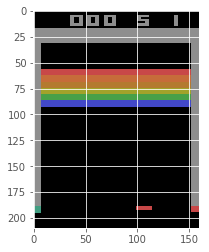

In [14]:
plt.imshow(np.array(obs0))
plt.show()

In [17]:
def preprocess(observation):
    observation = cv2.cvtColor(cv2.resize(observation, (84, 110)), cv2.COLOR_BGR2GRAY)
    observation = observation[26:110 ,:]
    ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(84,84,1))

After processing: (84, 84, 1)


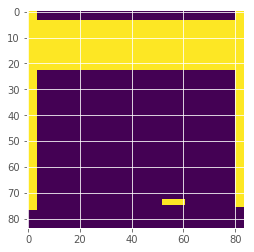

In [18]:
obs0 = preprocess(obs0)
print("After processing: " + str(np.array(obs0).shape))
plt.imshow(np.array(np.squeeze(obs0)))
plt.show()

In [19]:
brain.setInitState(obs0)
brain.currentState = np.squeeze(brain.currentState)

# Training model 

In [22]:
def train(env, brain):
    while True:
        action = brain.getAction()
        actionmax = np.argmax(np.array(action))
        nextObservation,reward,terminal, info = env.step(actionmax)
        
        if terminal:
            nextObservation = env.reset()
        nextObservation = preprocess(nextObservation)
        brain.setPerception(nextObservation,action,reward,terminal)

In [23]:
train(env, brain)

TIMESTEP 10000 / STATE explore / EPSILON 0.9954991000001482


KeyboardInterrupt: 

# Drawing result of training process

In [ ]:
def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))

In [ ]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [ ]:
frameshistory = []
observation = env.reset()
backupepsilon = brain.epsilon

brain.epsilon = 0.1
episode = 1
while episode != 0:
    action = brain.getAction()
    
#     print(action)
    actionmax = np.argmax(np.array(action))
    
    nextObservation,reward,terminal, info = env.step(actionmax)
    if terminal:
        nextObservation = env.reset()
        episode -= 1
    frameshistory.append(nextObservation)
    nextObservation = preprocess(nextObservation)
    brain.setPerception(nextObservation,action,reward,terminal)
brain.epsilon = backupepsilon
    
display_frames_as_gif(frameshistory)

# display_frames_as_gif(frameshistory,  game + '.gif')